## The Beauty of Zarr @ PyCon DE and PyData Berlin 2023 on 4/19



### Review NumPy

Zarr's Python API borrows many concepts from NumPy. So let's dive into basics of NumPy first.

In [1]:
import numpy as np
import zarr
import fsspec
from PIL import Image
from matplotlib import pyplot
from pprint import pprint as print

Creating an array:

In [2]:
a = np.zeros(shape=(10, 20), dtype='f8')
a.shape, a.dtype

((10, 20), dtype('float64'))

This arrays lives in memory, but how mmuch memory does the array use?

In [3]:
a.nbytes

1600

Getting a pice of data with slicing:

In [4]:
a[:2, :2]

array([[0., 0.],
       [0., 0.]])

Create a new array and assign to it:

In [5]:
b = np.ones(shape=(40, 50), dtype='f8')
b[:10, :20] = a

In [6]:
b[0, 0], b[-1, -1]

(0.0, 1.0)

## Zarr Fundamentals

A Zarr arrays has three important properties:

- Shape
- Dtype
- Attributes

In [7]:
z = zarr.create(shape=(1000, 1000), chunks=(10, 10), dtype='f8', store='test.zarr')
z

<zarr.core.Array (1000, 1000) float64>

In [8]:
z.info

Type,zarr.core.Array
Data type,float64
Shape,"(1000, 1000)"
Chunk shape,"(10, 10)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,8000000 (7.6M)
No. bytes stored,341
Storage ratio,23460.4


In [9]:
z.fill_value

0.0

No data has been written to the array yet. If we try to access data, we will just get the fill value:

In [10]:
z[0, 0]

0.0

This is how we assign data to the array, When we do this it gets written immediately.

In [11]:
z[499:999] = 2

In [12]:
z[0,0]

0.0

In [13]:
z.info

Type,zarr.core.Array
Data type,float64
Shape,"(1000, 1000)"
Chunk shape,"(10, 10)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,8000000 (7.6M)
No. bytes stored,215141 (210.1K)
Storage ratio,37.2


### Attributes

We can attach arbitrary metadata to our Array via attributes:

In [14]:
z.attrs['units'] = 'm/s'
z.attrs['standard_name'] = 'wind_speed'

In [15]:
print(dict(z.attrs))

{'standard_name': 'wind_speed', 'units': 'm/s'}


### Under the hood

Where/How is our data actually stored? Let's have a look under the hood. *The ability to look inside a Zarr store and understand what is there is a deliberate design decision.*

In [16]:
z.store

In [17]:
!tree -a test.zarr | head

test.zarr
├── .zarray
├── .zattrs
├── 49.0
├── 49.1
├── 49.10
├── 49.11
├── 49.12
├── 49.13
├── 49.14


In [18]:
import json
with open('test.zarr/.zarray') as fp:
    print(json.load(fp))

{'chunks': [10, 10],
 'compressor': {'blocksize': 0,
                'clevel': 5,
                'cname': 'lz4',
                'id': 'blosc',
                'shuffle': 1},
 'dtype': '<f8',
 'fill_value': 0.0,
 'filters': None,
 'order': 'C',
 'shape': [1000, 1000],
 'zarr_format': 2}


In [19]:
with open('test.zarr/.zattrs') as fp:
    print(json.load(fp))

{'standard_name': 'wind_speed', 'units': 'm/s'}


### Creating a Zarr group; hierarchical organization of arrays!

In [20]:
g1 = zarr.group()
g2 = g1.create_group('foo')
g3 = g1.create_group('bar')
g3.create_group('baz')
g3.create_dataset('xxx', shape=100)
g3.create_dataset('yyy', shape=(100, 100), dtype='i4')
g5 = g3.create_group('quux')
g5.create_dataset('aaa', shape=100)
g5.create_dataset('bbb', shape=(100, 100), dtype='i4')
g7 = g3.create_group('zoo')

In [21]:
print(g1.tree())

/
 ├── bar
 │   ├── baz
 │   ├── quux
 │   │   ├── aaa (100,) float64
 │   │   └── bbb (100, 100) int32
 │   ├── xxx (100,) float64
 │   ├── yyy (100, 100) int32
 │   └── zoo
 └── foo


In [22]:
g1.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='bar', nodes=(Node(disabled=True, na…

## Let's try converting Zarr 'pixelated' logo from `.png` to `.zarr`. ;)

### Opening the Zarr logo using PIL

In [23]:
image = Image.open("/Users/msankeys963/Downloads/Zarr Logos/Pixel/zarr_pixel.png")

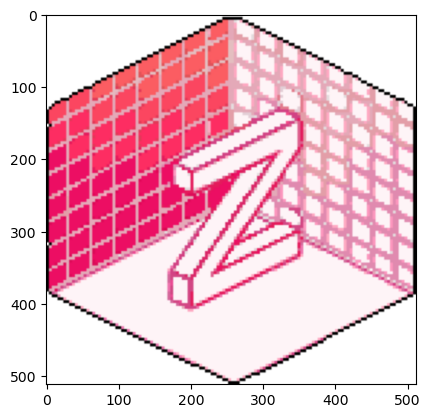

In [24]:
pyplot.imshow(image)

## Converting the Zarr logo into NumPy array using [asarray](https://numpy.org/doc/stable/reference/generated/numpy.asarray.html) function

In [25]:
numpydata = np.asarray(image)

In [26]:
type(numpydata)

numpy.ndarray

In [27]:
print(numpydata.shape)

(512, 512, 4)


In [28]:
print(numpydata)

array([[[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       ...,

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255

## Converting NumPy array into Zarr array using [zarr.array](https://zarr.readthedocs.io/en/stable/api/creation.html#zarr.creation.array) function

In [29]:
zarr_logo_zarr = zarr.array(numpydata)

In [30]:
zarr_logo_zarr.info

Type,zarr.core.Array
Data type,uint8
Shape,"(512, 512, 4)"
Chunk shape,"(256, 256, 4)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.KVStore
No. bytes,1048576 (1.0M)
No. bytes stored,107878 (105.3K)
Storage ratio,9.7


In [31]:
zarr_logo_zarr.attrs["Style"] = "Pixelated"
zarr_logo_zarr.attrs["Copyright"] = "Sanket"
zarr_logo_zarr.attrs["Motivation"] = "PyCon DE 2023"

In [32]:
print(dict(zarr_logo_zarr.attrs))

{'Copyright': 'Sanket', 'Motivation': 'PyCon DE 2023', 'Style': 'Pixelated'}


## Saving Zarr array (Zarr Pixel Logo)

In [33]:
zarr.save("zarr_logo_temp.zarr", zarr_logo_zarr)

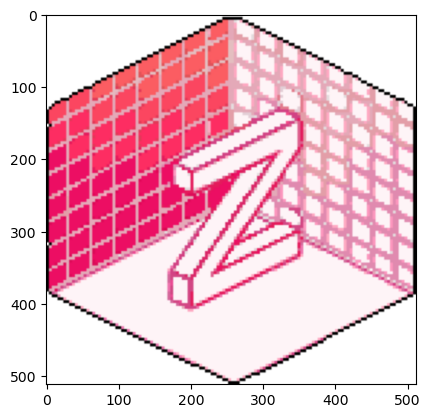

In [34]:
pyplot.imshow(zarr_logo_zarr)

## Reading a Zarr Data from the Cloud

In [35]:
g1 = zarr.open_group(
    "s3://power-analysis-ready-datastore/power_901_monthly_meteorology_utc.zarr",
    storage_options={"anon": True}
)

(492, 361, 576)


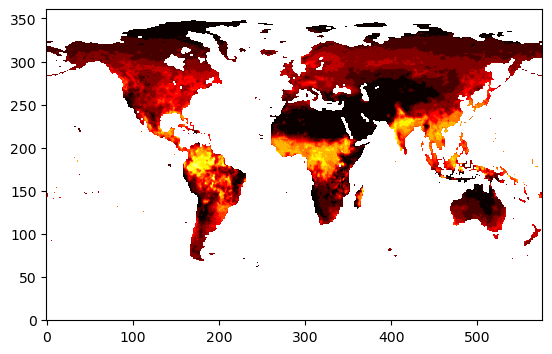

In [41]:
# print(list(g1.keys()))
z1 = g1["EVLAND"]
print(z1.shape)
pyplot.imshow(z1[200], origin="lower", cmap="hot")